In [6]:
import sys
import fiona
import numpy as np
import pandas as pd
import xarray as xr
import rasterio.features
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datacube import Datacube
from datacube.utils import geometry
from datacube.storage import masking
from scipy.signal import argrelextrema
from datacube.utils import geometry
from datetime import datetime
import fiona
import rasterio.features
import os

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../Scripts')
import DEAPlotting
import DEADataHandling
import BandIndices


%load_ext autoreload
%autoreload 2


# Connect to datacube
dc = Datacube(app='Flood drawdown')

# Import functions
def abline(slope, intercept, plot_kwargs):
    
    """
    Plot a line from slope and intercept
    """
    
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', **plot_kwargs) 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
# Set working dir
os.chdir('/g/data/r78/rt1527/dea-notebooks/Enviroflows')

# # Start and end period
# start_string, end_string = '2014-05-01', '2017-07-30'
# study_area_shp = 'raw_data/macmarsh/redgumreeds_reeds.shp'
# hydrograph_csv = 'raw_data/macmarsh/FlowData.csv'
# days_since = False
# study_area = 'macmarsh_reeds'
# pretty_title = "Macquarie Marsh, Common reeds"
# tci_wetness_threshhold = -600
# gooddata_threshold = 0.5

# # Start and end period
# start_string, end_string = '2014-05-01', '2017-07-30'
# study_area_shp = 'raw_data/macmarsh/redgumreeds_gums.shp'
# hydrograph_csv = 'raw_data/macmarsh/FlowData.csv'
# days_since = False
# study_area = 'macmarsh_gums'
# pretty_title = "Macquarie Marsh, River Red Gum complex"
# tci_wetness_threshhold = -600
# gooddata_threshold = 0.5


# Start and end period
start_string, end_string = '2013-08-28', '2017-07-30',  #'2014-01-01', '2017-07-30',  #
study_area_shp = 'raw_data/hattahlakes/hattahlakes_south.shp'
hydrograph_csv = 'raw_data/euston_flow.csv'
days_since = False
study_area = 'hattahlakes_south'
pretty_title = "Hattah Lakes, south complex"
tci_wetness_threshhold = -600
gooddata_threshold = 0.5

# # Start and end period
# start_string, end_string = '2014-01-01', '2017-07-30'
# study_area_shp = 'raw_data/hattahlakes/hattahlakes_north.shp'
# hydrograph_csv = 'raw_data/euston_flow.csv'
# days_since = False
# study_area = 'hattahlakes_north'
# pretty_title = "Hattah Lakes, north complex"
# tci_wetness_threshhold = -600
# gooddata_threshold = 0.5




# /g/data/r78/rt1527/dea-notebooks/Enviroflows/

## Extract local minima and maxima

In [ ]:
# # Set area over which index values should be averaged
# df = pd.read_csv(hydrograph_csv, index_col='date', parse_dates=True, dayfirst=True)
# df.rename(columns={'mean':'data'}, inplace=True)

# # Subset to time limit
# df = df[(df.index >= '2008-01-01') & (df.index <= '2018-12-30')]
# # df = df[(df.index >= '1998-01-01') & (df.index <= '2005-12-30')]

# # Find local peaks
# n = 120
# df['min'] = df.iloc[argrelextrema(df.data.values, np.less_equal, order=n)[0],0]
# df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal, order=n)[0],0]

# # Plot results
# plt.scatter(df.index, df['min'], c='r')
# plt.scatter(df.index, df['max'], c='g')
# plt.plot(df.index, df['data'])
# plt.show()


### Identify start and end date for flood

In [ ]:
# # Choose desired maxima; 9
# maxima_i = 9

# # Extract the start time based on maxima, and the end time based on subsequent minima
# date_start = df.dropna(subset=['max']).index.date[maxima_i]
# date_end = df.dropna(subset=['min']).truncate(before=date_start).iloc[0:1].index.date[0]
# print(date_start.isoformat(), date_end.isoformat())

# # Plot hydrograph between maxima and minima only
# df[(df.index >= date_start.isoformat()) & (df.index <= date_end.isoformat())].plot()

# # Get string format from dates
# start_string, end_string = date_start.isoformat(), date_end.isoformat()

## Import WOFLs and Landsat data

In [135]:
# Get geom from shapefile
with fiona.open(study_area_shp) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

# Create query from time period and geom
query = {'geopolygon': geom,
         'time':(start_string, end_string)}

# Extract WOFS and Landsat
WOFL = dc.load(product='wofs_albers', **query)
landsat = DEADataHandling.load_clearlandsat(dc=dc, query=query, masked_prop=0.01, 
                                            ls7_slc_off=True, apply_mask=True,
                                            mask_dict={'cloud_acca': 'no_cloud', 
                                                       'cloud_fmask': 'no_cloud',  
                                                       'cloud_shadow_acca':'no_cloud_shadow',
                                                       'cloud_shadow_fmask':'no_cloud_shadow',
                                                       'blue_saturated':False,
                                                       'green_saturated':False,
                                                       'red_saturated':False,
                                                       'nir_saturated':False,
                                                       'swir1_saturated':False,
                                                       'swir2_saturated':False,
                                                       'contiguous':True})


    Skipping ls5
Loading ls7 PQ
    Loading 58 filtered ls7 timesteps
Loading ls8 PQ
    Loading 65 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


## Identify wet and water pixels and normalise by proportion of valid data

In [136]:
# Identify all wet pixels
wofls_water = masking.make_mask(WOFL, wet = True)
# wofls_water.water.plot(col='time', col_wrap=5)

# Identify only WOFLs pixels with valid data 
wofls_gooddata = masking.make_mask(WOFL, 
                                   cloud=False,
                                   cloud_shadow=False,
                                   high_slope=False,
                                   noncontiguous=False,
                                   terrain_or_low_angle=False)

# Compute thresholded tasselled cap
landsat_wetness = BandIndices.tasseled_cap(landsat, tc_bands=['wetness'], drop=True) > tci_wetness_threshhold

# Identify Landsat pixels with valid data
landsat_gooddata = ~landsat.isnull()

# Create mask from polygon to match input data
polygon_mask = rasterio.features.geometry_mask([geom.to_crs(WOFL.geobox.crs) for geoms in [geom]],
                                                out_shape=WOFL.geobox.shape,
                                                transform=WOFL.geobox.affine,
                                                all_touched=False,
                                                invert=True)

# Use polygon mask to extract only pixels of arrays within polygon
wofls_water_masked = wofls_water.where(polygon_mask)
wofls_gooddata_masked = wofls_gooddata.water.where(polygon_mask)
landsat_wetness_masked = landsat_wetness.where(polygon_mask)
landsat_gooddata_masked = landsat_gooddata.red.where(polygon_mask)

# Compute total area of polygon and total area of valid data
polygon_area = polygon_mask.sum()
wofls_gooddata_area = wofls_gooddata_masked.sum(dim=['x','y'])
landsat_gooddata_area = landsat_gooddata_masked.sum(dim=['x','y'])

# Calculate normalised percentages
wofls_water_prop = wofls_water_masked.sum(dim=['x','y']) / wofls_gooddata_area
landsat_wetness_prop = landsat_wetness_masked.sum(dim=['x','y']) / landsat_gooddata_area

# Calculate percentage nodata as proportion of entire polygon study area
gooddata_prop = (wofls_gooddata_area / polygon_area)

# Keep only timesteps with greater than 70% data per timestep 
to_keep = gooddata_prop > gooddata_threshold
wofls_water_prop = wofls_water_prop.where(to_keep, drop=True)
landsat_wetness_prop = landsat_wetness_prop.where(to_keep, drop=True)

# Combine into a single dataframe
output_df = xr.auto_combine([landsat_wetness_prop, wofls_water_prop]).to_dataframe()

## Plot time series

In [ ]:
# Compute days since flood peak
output_df['flood_peak'] = datetime.strptime(start_string, "%Y-%m-%d")
output_df['days_since_peak'] = (output_df.index - output_df['flood_peak']).dt.days

# Calculate stats
x = output_df.days_since_peak.values
y = output_df.wetness.values
model = sm.OLS(y, sm.add_constant(x)).fit()

# Optionally set to days since vs date
if days_since:
    
    # Rename and plot
    plotting_df = output_df[['wetness', 'water', 'days_since_peak']].set_index('days_since_peak')
    plotting_df = plotting_df.rename(columns={'wetness':'Wet terrain & vegetation', 'water':'Standing water'})
    plotting_df.plot(figsize=(10, 7))
    plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
    
else:
   
    # Rename and plot
    plotting_df = output_df[['wetness', 'water']]
    plotting_df = plotting_df.rename(columns={'wetness':'Wet terrain & vegetation', 'water':'Standing water'})
    plotting_df.plot(figsize=(10, 7))
    plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])

# Export to file
plt.savefig("figures/{}_{}_{}.png".format(study_area, start_string, end_string), pad_inches = 0, dpi=300, bbox_inches='tight') 

## Default for Mac Marshes

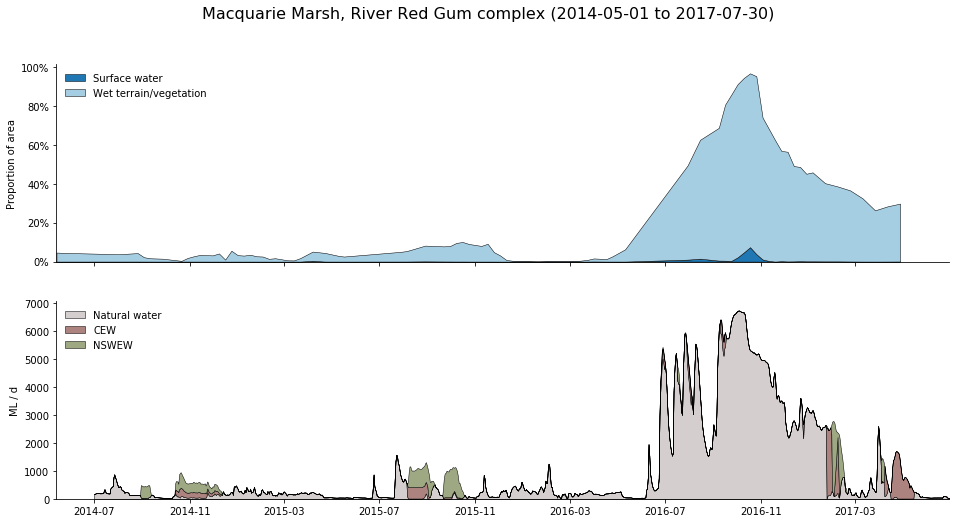

In [5]:
# Import hydrograph
hydrograph_df = pd.read_csv(hydrograph_csv, index_col='Date', parse_dates=True, dayfirst=True, usecols=[0, 1, 2, 3])

# Compute natural flow
hydrograph_df['Natural'] = hydrograph_df['Flow'] - hydrograph_df['NSWEW'] - hydrograph_df['CEW']
hydrograph_df = hydrograph_df.drop(columns='Flow')

# For TC plot, substract WOFS from tassel cap wetness
plotting_df = output_df[['wetness', 'water']]
plotting_df['wetness_nowater'] = output_df['wetness'] - output_df['water']
plotting_df

# Create plot
fig, axes = plt.subplots(2,1, figsize=(16,8), sharex=True)
axes[0].stackplot(plotting_df.index, plotting_df.water, plotting_df.wetness_nowater, 
                  labels=['Surface water', 'Wet terrain/vegetation'],
                  colors=["#1f78b4", "#a6cee3"], edgecolor='black', linewidth=0.5)
axes[0].set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
axes[1].stackplot(hydrograph_df.index,hydrograph_df.Natural, hydrograph_df.CEW, hydrograph_df.NSWEW, 
                  labels=['Natural water','CEW','NSWEW'],
                  colors=["#d5cece","#ac837f","#9ea983"], edgecolor='black', linewidth=0.5)

# Add axis title
axes[0].set_ylabel('Proportion of area')
axes[1].set_ylabel('ML / d')

# Fix axes
axes[0].margins(x=0)
axes[1].margins(x=0)

# Add legends
axes[1].legend(loc=2, frameon=False)
axes[0].legend(loc=2, frameon=False)

# Remove spines
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

# Add overall title
plt.suptitle("{} ({} to {})".format(pretty_title, start_string, end_string), fontsize=16);
 
# Save and plot
plt.savefig("figures/{}_{}_{}_hydrograph.png".format(study_area, start_string, end_string), pad_inches = 0, dpi=300, bbox_inches='tight') 

## Default for Hattah

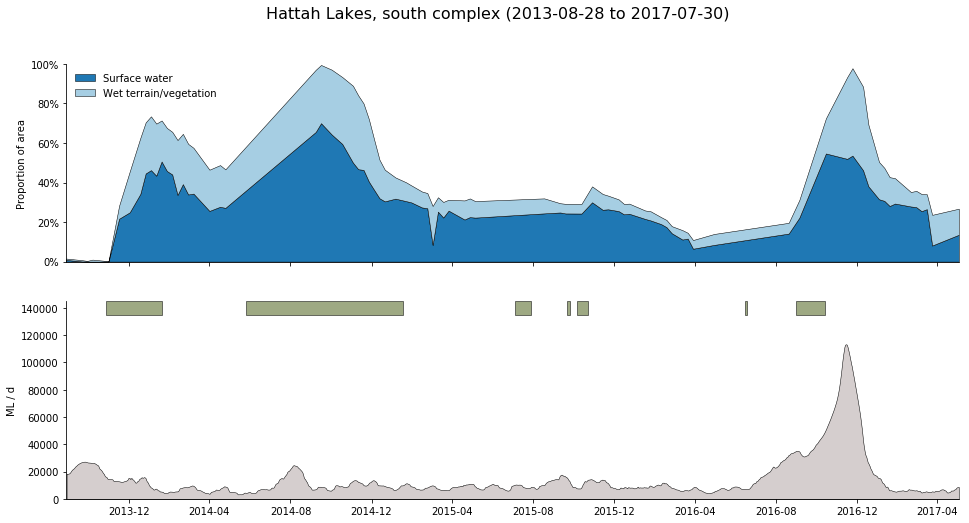

In [137]:
# Import hydrograph
hydrograph_df = pd.read_csv(hydrograph_csv, index_col='date', parse_dates=True, dayfirst=True, usecols=[0, 1])
hydrograph_df = hydrograph_df.rename(columns={'mean':'Natural'})
hydrograph_df = hydrograph_df[(hydrograph_df.index >= output_df.index[0]) & (hydrograph_df.index <= output_df.index[-1])]
hydrograph_df

# For TC plot, substract WOFS from tassel cap wetness
plotting_df = output_df[['wetness', 'water']]
plotting_df['wetness_nowater'] = output_df['wetness'] - output_df['water']
plotting_df

# Create plot
fig, axes = plt.subplots(2,1, figsize=(16,8), sharex=True)
axes[0].stackplot(plotting_df.index, plotting_df.water, plotting_df.wetness_nowater, 
                  labels=['Surface water', 'Wet terrain/vegetation'],
                  colors=["#1f78b4", "#a6cee3"], edgecolor='black', linewidth=0.5)
axes[0].set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
axes[1].stackplot(hydrograph_df.index, hydrograph_df.Natural,
                  labels=['Flow'],
                  colors=["#d5cece"], edgecolor='black', linewidth=0.5)

# Add axis title
axes[0].set_ylabel('Proportion of area')
axes[1].set_ylabel('ML / d')

# Fix axes
axes[0].margins(x=0)
axes[1].margins(x=0)
axes[0].margins(y=0)
axes[1].margins(y=0)
axes[0].set_ylim([0, 1.0])

# Add legends
# axes[1].legend(loc=2, frameon=False)
axes[0].legend(loc=2, frameon=False)

# Remove spines
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

# Add overall title
plt.suptitle("{} ({} to {})".format(pretty_title, start_string, end_string), fontsize=16)

# Add enviro flow overlay
test = pd.read_csv('raw_data/hattahlakes/hattahlakes_enviroflows.csv', parse_dates=[1,2])
test['length'] = (test.Stop - test.Start).dt.days
edate, bdate = [mdates.date2num(item) for item in (test.Start, test.Stop)]
axes[1].barh(y=140000, width=edate - bdate, height=10000, left=bdate, 
             color='#9ea983', edgecolor='black', linewidth=0.5)
axes[1].xaxis_date()

#Save and plot
# plt.savefig("figures/{}_{}_{}_hydrograph.png".format(study_area, start_string, end_string), pad_inches = 0, dpi=300, bbox_inches='tight') 

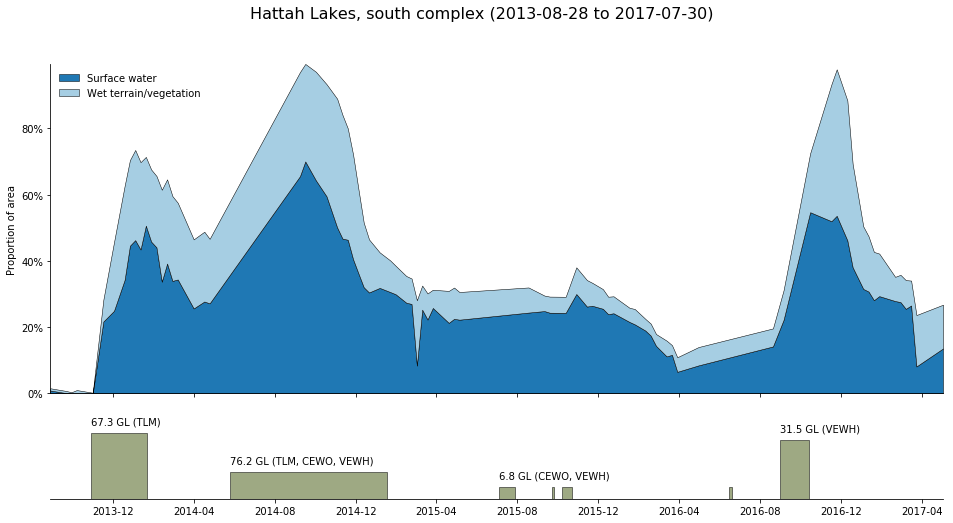

In [275]:
# For TC plot, substract WOFS from tassel cap wetness
plotting_df = output_df[['wetness', 'water']]
plotting_df['wetness_nowater'] = output_df['wetness'] - output_df['water']
plotting_df

# Create plot
fig, axes = plt.subplots(2,1, figsize=(16,8), sharex=True, gridspec_kw = {'height_ratios':[1, 0.2]})
axes[0].stackplot(plotting_df.index, plotting_df.water, plotting_df.wetness_nowater, 
                  labels=['Surface water', 'Wet terrain/vegetation'],
                  colors=["#1f78b4", "#a6cee3"], edgecolor='black', linewidth=0.5)
axes[0].set_yticklabels(['{:,.0%}'.format(x) for x in axes[0].get_yticks()])

# Add axis title
axes[0].set_ylabel('Proportion of area')

# Fix axes
axes[0].margins(x=0)
axes[1].margins(x=0)
axes[0].margins(y=0)
axes[1].margins(y=0)
# axes[0].set_ylim([0, 1.0])

# Add legends
# axes[1].legend(loc=2, frameon=False)
axes[0].legend(loc=2, frameon=False)

# Remove spines
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)

# Add overall title
plt.suptitle("{} ({} to {})".format(pretty_title, start_string, end_string), fontsize=16)

# Add enviro flow overlay
test = pd.read_csv('raw_data/hattahlakes/hattahlakes_enviroflows.csv', parse_dates=[1,2])
test['length'] = (test.Stop - test.Start).dt.days
test['rate'] = test.Amount/test.groupby(['Event'])['length'].transform('sum')
edate, bdate = [mdates.date2num(item) for item in (test.Start, test.Stop)]
axes[1].barh(y=0, width=edate - bdate, left=bdate, height=test.rate, 
             color='#9ea983', edgecolor='black', linewidth=0.5, align='edge')



# Add each text annotation to plot                  
for event in np.unique(test.Event):
    amount = test[test.Event == event].iloc[0, 3]
    who = np.unique(test[test.Event == event]['Desc'])
    who_string = ", ".join(who) if len(who) > 1 else who[0]
    how_high = test[test.Event == event].iloc[0, 6]
#     how_high = 1
    axes[1].text(x=mdates.date2num(test[test.Event == event].iloc[0, 1]), 
                 y=how_high + 0.1, s='{} GL ({})'.format(amount, who_string))

# Revert axis to date
axes[1].xaxis_date()
axes[1].get_yaxis().set_visible(False)


#Save and plot
plt.savefig("figures/{}_{}_{}_enviroflows_volume.png".format(study_area, start_string, end_string), pad_inches = 0, dpi=300, bbox_inches='tight') 

In [263]:
plt.barh

In [270]:
test[test.Event == event].iloc[0, 6]

0.7159090909090909